In [2]:
from qiskit import QuantumCircuit, QuantumRegister
import numpy as np

# imports for generating training circuits
from qiskit.circuit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from qiskit.transpiler import TransformationPass
import numpy as np
import random
from random import choices


nqubits = 2
nshots = 20000

def getParity(n):
    parity = 0
    while n:
        parity = ~parity
        n = n & (n - 1)
    return parity

import itertools
def expectation_value_from_counts(counts):
    exp_val = 0
    for x in map(''.join, itertools.product('01', repeat=nqubits)):
        if x in counts:   # making sure that x is in the output as the counts dictionary contains no values with 0 occurrence
            if getParity(int(x,2)) == -1:
                exp_val = exp_val - counts[x]
            if getParity(int(x,2)) == 0:
                exp_val = exp_val + counts[x]
    return exp_val/nshots

# mapping circuit to near Clifford circuits with N = number of non-Clifford gates
# Z gates with these angles/exponents are Clifford gates.
clifford_exponents = np.array([0.0, 0.5, 1.0, 1.5])
clifford_angles = [exponent * np.pi for exponent in clifford_exponents]


# replacing some non-Clifford gates in the input circuit

# NEED TO TREAT RX AS NON-CLIFFORD INSTEAD?????????????????????????????

class RZTranslator(TransformationPass):
    """A transpiler pass to replace RZ(a) gates with RZ(pi/2)^n gates, for n = 0, 1, 2, 3 at random."""

    def run(self, dag):
        N = 0.3  # we want to replace 10% of the non-Clifford gates
        # iterate over all operations
        for node in dag.op_nodes():

            # if we hit a RZ gate replace it by RZ(pi/2)^n at random
            if node.op.name in ["rz"]:
                # get the rotation angle
                angle = node.op.params[0]

                # calculate the replacement
                replacement = QuantumCircuit(1)
                if node.op.name == "rz":
                    if angle not in clifford_angles:
                        if choices([0,1], [N, 1-N])[0] == 0:
                            replacement.rz(random.choice(clifford_angles),0)
                        else:
                            replacement.rz(angle,0)

                # replace the node with our new decomposition
                dag.substitute_node_with_dag(node, circuit_to_dag(replacement))
        
        return dag
   
    
# Least-squares regression from scipy
#from scipy.stats import linregress
def least_squares_regression(noiseless_exp_vals, noisy_exp_vals):
    result = scipy.stats.linregress(noisy_exp_vals, noiseless_exp_vals)
    return (result.slope, result.intercept)


def append_gates(qc):
    for rep in range(5):
        for qubit in range(nqubits):
            qc.h(qubit)  # Clifford
        for qubit in range(nqubits)[::2]:
            qc.rz(1.75, qubit)
        for qubit in range(nqubits)[1::2]:
            qc.rz(2.31, qubit)
        for qubit in range(nqubits)[::2]:
            qc.cx(qubit, qubit+1)     # Clifford
        for qubit in range(nqubits)[::2]:
            qc.rz(-1.17, qubit)
        for qubit in range(nqubits)[1::2]:
            qc.rz(3.23, qubit)
        for qubit in range(nqubits):
            qc.rx(np.pi/2, qubit)    # Clifford
    return qc

# The original vcircuit
qc = QuantumCircuit(nqubits)
append_gates(qc)

training_circuits_no_measurement_all = []  
for _ in range(500):
    training_circuits_no_measurement_all.append(RZTranslator()(qc))

print(*training_circuits_no_measurement_all)

     ┌───┐┌──────────┐      ┌───────┐  ┌─────────┐┌───┐┌──────────┐     »
q_0: ┤ H ├┤ Rz(1.75) ├──■───┤ Rz(0) ├──┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──»
     ├───┤├──────────┤┌─┴─┐┌┴───────┴─┐├─────────┤├───┤├──────────┤┌─┴─┐»
q_1: ┤ H ├┤ Rz(2.31) ├┤ X ├┤ Rz(3π/2) ├┤ Rx(π/2) ├┤ H ├┤ Rz(2.31) ├┤ X ├»
     └───┘└──────────┘└───┘└──────────┘└─────────┘└───┘└──────────┘└───┘»
«     ┌──────────┐┌─────────┐┌───┐┌──────────┐     ┌───────────┐┌─────────┐»
«q_0: ┤ Rz(3π/2) ├┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├»
«     ├──────────┤├─────────┤├───┤├──────────┤┌─┴─┐└┬──────────┤├─────────┤»
«q_1: ┤ Rz(3.23) ├┤ Rx(π/2) ├┤ H ├┤ Rz(2.31) ├┤ X ├─┤ Rz(3.23) ├┤ Rx(π/2) ├»
«     └──────────┘└─────────┘└───┘└──────────┘└───┘ └──────────┘└─────────┘»
«     ┌───┐┌──────────┐     ┌───────────┐┌─────────┐┌───┐┌──────────┐     »
«q_0: ┤ H ├┤ Rz(1.75) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──»
«     ├───┤└┬───────┬─┘┌─┴─┐└─┬───────┬─┘├─────────┤├───┤├──────────┤┌─┴─┐»
«q_1: ┤ H ├─┤ Rz(

«     └──────────┘└─────────┘      ┌───┐┌──────────┐     ┌───────────┐┌─────────┐┌───┐┌──────────┐     »
q_0: ┤ H ├┤ Rz(1.75) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──»
     ├───┤├──────────┤┌─┴─┐└┬──────────┤├─────────┤├───┤├──────────┤┌─┴─┐»
q_1: ┤ H ├┤ Rz(2.31) ├┤ X ├─┤ Rz(3.23) ├┤ Rx(π/2) ├┤ H ├┤ Rz(2.31) ├┤ X ├»
     └───┘└──────────┘└───┘ └──────────┘└─────────┘└───┘└──────────┘└───┘»
«     ┌──────────┐┌─────────┐┌───┐┌──────────┐     ┌─────────┐ ┌─────────┐┌───┐»
«q_0: ┤ Rz(3π/2) ├┤ Rx(π/2) ├┤ H ├┤ Rz(3π/2) ├──■──┤ Rz(π/2) ├─┤ Rx(π/2) ├┤ H ├»
«     ├──────────┤├─────────┤├───┤├──────────┤┌─┴─┐├─────────┴┐├─────────┤├───┤»
«q_1: ┤ Rz(3.23) ├┤ Rx(π/2) ├┤ H ├┤ Rz(2.31) ├┤ X ├┤ Rz(3.23) ├┤ Rx(π/2) ├┤ H ├»
«     └──────────┘└─────────┘└───┘└──────────┘└───┘└──────────┘└─────────┘└───┘»
«     ┌──────────┐     ┌───────────┐┌─────────┐┌───┐┌──────────┐     »
«q_0: ┤ Rz(3π/2) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──»
«     ├──────────┤┌─┴─┐└─┬───────┬─┘├─────────┤├

«       └───────┘  └─────────┘      ┌───┐┌──────────┐     ┌───────────┐┌─────────┐┌───┐┌──────────┐     »
q_0: ┤ H ├┤ Rz(1.75) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├┤ Rz(3π/2) ├──■──»
     ├───┤├──────────┤┌─┴─┐└┬──────────┤├─────────┤├───┤└┬───────┬─┘┌─┴─┐»
q_1: ┤ H ├┤ Rz(2.31) ├┤ X ├─┤ Rz(3.23) ├┤ Rx(π/2) ├┤ H ├─┤ Rz(0) ├──┤ X ├»
     └───┘└──────────┘└───┘ └──────────┘└─────────┘└───┘ └───────┘  └───┘»
«     ┌───────────┐┌─────────┐┌───┐┌──────────┐      ┌───────┐  ┌─────────┐»
«q_0: ┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■───┤ Rz(π) ├──┤ Rx(π/2) ├»
«     └┬─────────┬┘├─────────┤├───┤├─────────┬┘┌─┴─┐┌┴───────┴─┐├─────────┤»
«q_1: ─┤ Rz(π/2) ├─┤ Rx(π/2) ├┤ H ├┤ Rz(π/2) ├─┤ X ├┤ Rz(3.23) ├┤ Rx(π/2) ├»
«      └─────────┘ └─────────┘└───┘└─────────┘ └───┘└──────────┘└─────────┘»
«     ┌───┐┌──────────┐     ┌───────────┐┌─────────┐┌───┐ ┌───────┐       »
«q_0: ┤ H ├┤ Rz(1.75) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├─┤ Rz(π) ├────■──»
«     ├───┤├──────────┤┌─┴─┐└┬──────────┤├─────────┤├───┤

«      └──────────┘└─────────┘      ┌───┐┌──────────┐     ┌───────────┐┌─────────┐┌───┐┌──────────┐     »
q_0: ┤ H ├┤ Rz(1.75) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──»
     ├───┤├──────────┤┌─┴─┐└─┬───────┬─┘├─────────┤├───┤└┬───────┬─┘┌─┴─┐»
q_1: ┤ H ├┤ Rz(2.31) ├┤ X ├──┤ Rz(π) ├──┤ Rx(π/2) ├┤ H ├─┤ Rz(π) ├──┤ X ├»
     └───┘└──────────┘└───┘  └───────┘  └─────────┘└───┘ └───────┘  └───┘»
«     ┌──────────┐┌─────────┐┌───┐┌──────────┐     ┌───────────┐┌─────────┐»
«q_0: ┤ Rz(3π/2) ├┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├»
«     └┬───────┬─┘├─────────┤├───┤├──────────┤┌─┴─┐└┬──────────┤├─────────┤»
«q_1: ─┤ Rz(0) ├──┤ Rx(π/2) ├┤ H ├┤ Rz(2.31) ├┤ X ├─┤ Rz(3.23) ├┤ Rx(π/2) ├»
«      └───────┘  └─────────┘└───┘└──────────┘└───┘ └──────────┘└─────────┘»
«     ┌───┐┌──────────┐     ┌───────────┐┌─────────┐┌───┐┌──────────┐     »
«q_0: ┤ H ├┤ Rz(1.75) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──»
«     ├───┤├──────────┤┌─┴─┐└┬──────────┤├─────────┤├───┤

«       └───────┘  └─────────┘      ┌───┐┌──────────┐     ┌───────────┐┌─────────┐┌───┐┌──────────┐     »
q_0: ┤ H ├┤ Rz(1.75) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──»
     ├───┤├──────────┤┌─┴─┐└┬──────────┤├─────────┤├───┤├──────────┤┌─┴─┐»
q_1: ┤ H ├┤ Rz(2.31) ├┤ X ├─┤ Rz(3.23) ├┤ Rx(π/2) ├┤ H ├┤ Rz(2.31) ├┤ X ├»
     └───┘└──────────┘└───┘ └──────────┘└─────────┘└───┘└──────────┘└───┘»
«     ┌───────────┐┌─────────┐┌───┐ ┌───────┐       ┌───────────┐┌─────────┐»
«q_0: ┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├─┤ Rz(π) ├────■──┤ Rz(-1.17) ├┤ Rx(π/2) ├»
«     └┬──────────┤├─────────┤├───┤┌┴───────┴─┐┌─┴─┐└─┬───────┬─┘├─────────┤»
«q_1: ─┤ Rz(3π/2) ├┤ Rx(π/2) ├┤ H ├┤ Rz(2.31) ├┤ X ├──┤ Rz(0) ├──┤ Rx(π/2) ├»
«      └──────────┘└─────────┘└───┘└──────────┘└───┘  └───────┘  └─────────┘»
«     ┌───┐┌──────────┐     ┌───────────┐┌─────────┐┌───┐ ┌───────┐       »
«q_0: ┤ H ├┤ Rz(1.75) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├─┤ Rz(0) ├────■──»
«     ├───┤├──────────┤┌─┴─┐└┬──────────┤├─────────┤

«     └──────────┘└─────────┘      ┌───┐┌──────────┐     ┌───────────┐┌─────────┐┌───┐┌──────────┐     »
q_0: ┤ H ├┤ Rz(3π/2) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──»
     ├───┤├──────────┤┌─┴─┐└┬──────────┤├─────────┤├───┤├──────────┤┌─┴─┐»
q_1: ┤ H ├┤ Rz(2.31) ├┤ X ├─┤ Rz(3.23) ├┤ Rx(π/2) ├┤ H ├┤ Rz(2.31) ├┤ X ├»
     └───┘└──────────┘└───┘ └──────────┘└─────────┘└───┘└──────────┘└───┘»
«     ┌───────────┐┌─────────┐┌───┐┌──────────┐     ┌───────────┐┌─────────┐»
«q_0: ┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├»
«     └┬──────────┤├─────────┤├───┤├──────────┤┌─┴─┐└┬──────────┤├─────────┤»
«q_1: ─┤ Rz(3.23) ├┤ Rx(π/2) ├┤ H ├┤ Rz(2.31) ├┤ X ├─┤ Rz(3.23) ├┤ Rx(π/2) ├»
«      └──────────┘└─────────┘└───┘└──────────┘└───┘ └──────────┘└─────────┘»
«     ┌───┐┌──────────┐     ┌───────────┐┌─────────┐┌───┐┌──────────┐     »
«q_0: ┤ H ├┤ Rz(1.75) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──»
«     ├───┤├──────────┤┌─┴─┐└┬──────────┤├─────────┤├

«     └──────────┘└─────────┘      ┌───┐┌──────────┐     ┌───────────┐┌─────────┐┌───┐ ┌───────┐       »
q_0: ┤ H ├┤ Rz(1.75) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├─┤ Rz(π) ├────■──»
     ├───┤├──────────┤┌─┴─┐└┬──────────┤├─────────┤├───┤┌┴───────┴─┐┌─┴─┐»
q_1: ┤ H ├┤ Rz(2.31) ├┤ X ├─┤ Rz(3.23) ├┤ Rx(π/2) ├┤ H ├┤ Rz(2.31) ├┤ X ├»
     └───┘└──────────┘└───┘ └──────────┘└─────────┘└───┘└──────────┘└───┘»
«      ┌───────┐  ┌─────────┐┌───┐ ┌───────┐       ┌──────────┐┌─────────┐┌───┐»
«q_0: ─┤ Rz(π) ├──┤ Rx(π/2) ├┤ H ├─┤ Rz(π) ├────■──┤ Rz(3π/2) ├┤ Rx(π/2) ├┤ H ├»
«     ┌┴───────┴─┐├─────────┤├───┤┌┴───────┴─┐┌─┴─┐└┬───────┬─┘├─────────┤├───┤»
«q_1: ┤ Rz(3.23) ├┤ Rx(π/2) ├┤ H ├┤ Rz(2.31) ├┤ X ├─┤ Rz(0) ├──┤ Rx(π/2) ├┤ H ├»
«     └──────────┘└─────────┘└───┘└──────────┘└───┘ └───────┘  └─────────┘└───┘»
«     ┌──────────┐      ┌───────┐  ┌─────────┐┌───┐┌──────────┐     »
«q_0: ┤ Rz(1.75) ├──■───┤ Rz(0) ├──┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──»
«     ├──────────┤┌─┴─┐┌┴───────┴─┐├─────────┤├───

In [3]:
# wrapping the circuit into a statefunction
# This does not take simulation output into account, hence is always the same, while simulation with measurement varies.
from qiskit.opflow import Z, StateFn, CircuitStateFn

observable = Z ^ 2

# expectation value of the original circuit
psi_qc = CircuitStateFn(qc)
exp_val_qc = (~psi_qc @ observable @ psi_qc).eval()
print('Exact expectation value of circuit of interest:', exp_val_qc.real)

noiseless_exp_vals = []   
training_circuits_no_measurement = []
for circuit in training_circuits_no_measurement_all: 
    psi = CircuitStateFn(circuit)
    expectation_value = (~psi @ observable @ psi).eval()
    if expectation_value >= exp_val_qc.real-0.05 and expectation_value <= exp_val_qc.real+0.05:
        noiseless_exp_vals.append(expectation_value.real)
        training_circuits_no_measurement.append(circuit)


for exp_val in noiseless_exp_vals:
    print('Exact expectation value:', exp_val)


Exact expectation value of circuit of interest: 0.20422260124463615
Exact expectation value: 0.1773036586824104
Exact expectation value: 0.20518024409345612
Exact expectation value: 0.24888557740824535
Exact expectation value: 0.18179179363230563
Exact expectation value: 0.23859661321413123
Exact expectation value: 0.21339591028020033
Exact expectation value: 0.24224831277989978
Exact expectation value: 0.23064574618716074
Exact expectation value: 0.15541467275168866
Exact expectation value: 0.24443464800104958
Exact expectation value: 0.19891663677943877
Exact expectation value: 0.16239487660936036
Exact expectation value: 0.16789901035344965
Exact expectation value: 0.16543378501798173
Exact expectation value: 0.24186734252190573
Exact expectation value: 0.203332121982332
Exact expectation value: 0.17981178821720345
Exact expectation value: 0.19424148332572364
Exact expectation value: 0.20242576326973147
Exact expectation value: 0.19867924491509625
Exact expectation value: 0.18871176

In [6]:

# Generate training circuits with measurement for noisy simulation on quantum devices

from qiskit import ClassicalRegister

# original circuit with measurement
qr_qc = QuantumRegister(nqubits)
cr_qc = ClassicalRegister(nqubits)
circ_qc = QuantumCircuit(qr_qc, cr_qc)
circ_qc.append(qc.to_instruction(), [qubit for qubit in range(nqubits)])
circ_qc.measure(qr_qc, cr_qc)

training_circuits_with_measurement = []
for circuit in training_circuits_no_measurement:
    qr = QuantumRegister(nqubits)
    cr = ClassicalRegister(nqubits)
    circ = QuantumCircuit(qr, cr)
    circ.append(circuit.to_instruction(), [qubit for qubit in range(nqubits)])
    circ.measure(qr, cr) 
    training_circuits_with_measurement.append(circ)
    #print(circ.decompose())
    
print(*training_circuits_with_measurement)

         ┌────────────────┐┌─┐   
q3543_0: ┤0               ├┤M├───
         │  circuit-10501 │└╥┘┌─┐
q3543_1: ┤1               ├─╫─┤M├
         └────────────────┘ ║ └╥┘
  c36: 2/═══════════════════╩══╩═
                            0  1           ┌────────────────┐┌─┐   
q3544_0: ┤0               ├┤M├───
         │  circuit-10501 │└╥┘┌─┐
q3544_1: ┤1               ├─╫─┤M├
         └────────────────┘ ║ └╥┘
  c37: 2/═══════════════════╩══╩═
                            0  1           ┌────────────────┐┌─┐   
q3545_0: ┤0               ├┤M├───
         │  circuit-10501 │└╥┘┌─┐
q3545_1: ┤1               ├─╫─┤M├
         └────────────────┘ ║ └╥┘
  c38: 2/═══════════════════╩══╩═
                            0  1           ┌────────────────┐┌─┐   
q3546_0: ┤0               ├┤M├───
         │  circuit-10501 │└╥┘┌─┐
q3546_1: ┤1               ├─╫─┤M├
         └────────────────┘ ║ └╥┘
  c39: 2/═══════════════════╩══╩═
                            0  1           ┌────────────────┐┌─┐   
q3547_0: ┤0   

In [7]:
# adding a noise model to simulation
from qiskit import transpile

from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeVigo

from qiskit.providers.aer import AerSimulator

device_backend = FakeVigo()
coupling_map = device_backend.configuration().coupling_map
sim_vigo = AerSimulator.from_backend(device_backend)

noisy_exp_vals = []   
for circuit in training_circuits_with_measurement: 
    tqc = transpile(circuit, sim_vigo) #
    result_noise = sim_vigo.run(tqc, shots=nshots).result() #
    counts_noise = result_noise.get_counts(0) #
    noisy_exp_val = expectation_value_from_counts(counts_noise) #
    print('Noisy expectation value from counts: ', noisy_exp_val)
    noisy_exp_vals.append(noisy_exp_val)

#print(noisy_exp_vals)

Noisy expectation value from counts:  0.1422
Noisy expectation value from counts:  0.1427
Noisy expectation value from counts:  0.1977
Noisy expectation value from counts:  0.1164
Noisy expectation value from counts:  0.166
Noisy expectation value from counts:  0.149
Noisy expectation value from counts:  0.1787
Noisy expectation value from counts:  0.1596
Noisy expectation value from counts:  0.1157
Noisy expectation value from counts:  0.1741
Noisy expectation value from counts:  0.1432
Noisy expectation value from counts:  0.1272
Noisy expectation value from counts:  0.0994
Noisy expectation value from counts:  0.109
Noisy expectation value from counts:  0.1534
Noisy expectation value from counts:  0.1352
Noisy expectation value from counts:  0.1445
Noisy expectation value from counts:  0.1136
Noisy expectation value from counts:  0.1468
Noisy expectation value from counts:  0.1446
Noisy expectation value from counts:  0.1158
Noisy expectation value from counts:  0.1393
Noisy expecta

In [8]:
import scipy

result = least_squares_regression(noiseless_exp_vals, noisy_exp_vals)

slope = result[0]
intercept = result[1]
print('Slope: ', slope, ' Intercept: ', intercept)

Slope:  1.050572652334497  Intercept:  0.05328023950919175


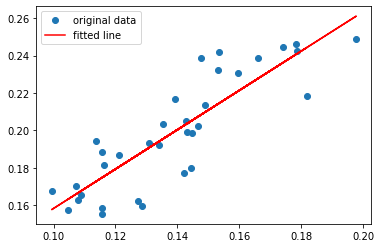

In [9]:
import matplotlib.pyplot as plt
plt.plot(noisy_exp_vals, noiseless_exp_vals, 'o', label='original data')
noisy_exp_vals = np.array(noisy_exp_vals)
plt.plot(noisy_exp_vals, slope*noisy_exp_vals + intercept, 'r', label='fitted line')

plt.legend()
plt.show()

In [10]:
# prediction: run the original circuit and measure (= X_exact). Then, apply the function X_exact = slope*X_noisy + intercept
# to obtain the mitigated value. 
# adding a noise model to simulation

# Run classical simulation
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

#print('Mathematically obtained expectation value:', expectation_value.real)

# Testing: classical exact expectation value from the original circuit
psi_test = CircuitStateFn(qc)
exact_exp_val_test = (~psi_test @ observable @ psi_test).eval().real
print('Exact expectation value: ', exact_exp_val_test)
'''
simulator = Aer.get_backend('qasm_simulator')
exact_result = execute(qc, simulator, shots=nshots).result()
exact_counts = exact_result.get_counts(qc)
exact_exp_val = expectation_value_from_counts(exact_counts)
print('Exact expectation value from counts: ', exact_exp_val)
'''
# Testing: quantum noisy expectation value on the original circuit

from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeVigo
from qiskit import transpile
from qiskit.providers.aer import AerSimulator
device_backend = FakeVigo()
coupling_map = device_backend.configuration().coupling_map
sim_vigo = AerSimulator.from_backend(device_backend)
tqc = transpile(circ_qc, sim_vigo) 
'''
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_lima')

tqc = transpile(qc_, qcomp) #
unmitigated_result = execute(qc, backend=qcomp, shots=nshots).result()
unmitigated_counts = unmitigated_result.get_counts(0) 
unmitigated_exp_val = expectation_value_from_counts(unmitigated_counts) 
print('Unmitigated expectation value from counts: ', unmitigated_exp_val)

'''
unmitigated_result = execute(circ_qc, backend=device_backend, shots=nshots).result() 
unmitigated_counts = unmitigated_result.get_counts(0) 
unmitigated_exp_val = expectation_value_from_counts(unmitigated_counts) 


# Mitigation
mitigated_exp_val = slope*unmitigated_exp_val + intercept
print('Mitigated expectation value from counts:', mitigated_exp_val)

# Error calculation
error_unmitigated = abs(unmitigated_exp_val-exact_exp_val_test)
error_mitigated = abs(mitigated_exp_val-exact_exp_val_test)
print("Error (unmitigated):", error_unmitigated)
print("Error (mitigated with CDR):", error_mitigated)

print("Relative error (unmitigated):", (error_unmitigated/exact_exp_val_test))
print("Relative error (mitigated with CDR):", error_mitigated/exact_exp_val_test)

print(f"Error reduction with CDR: {(error_unmitigated-error_mitigated)/error_unmitigated :.1%}.")

Exact expectation value:  0.20422260124463615
Mitigated expectation value from counts: 0.2005705253664882
Error (unmitigated): 0.06402260124463616
Error (mitigated with CDR): 0.003652075878147948
Relative error (unmitigated): 0.3134942012022663
Relative error (mitigated with CDR): 0.017882819315248873
Error reduction with CDR: 94.3%.
